## Exploratory Data Analysis

In [1]:
from google.colab import drive
drive.mount('/content/drive/')
!cp "drive/MyDrive/Colab Notebooks/AutoInsurance.zip" "/content/AutoInsurance.zip"

!unzip AutoInsurance.zip
!rm AutoInsurance.zip

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
Archive:  AutoInsurance.zip
replace train(1).csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [3]:
df=pd.read_csv('train(1).csv')
df[:5]

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,...,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,...,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,...,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,...,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,...,3,1,1,3,0,0,0,1,1,0


###  Inferences

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 595212 entries, 0 to 595211
Data columns (total 59 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id              595212 non-null  int64  
 1   target          595212 non-null  int64  
 2   ps_ind_01       595212 non-null  int64  
 3   ps_ind_02_cat   595212 non-null  int64  
 4   ps_ind_03       595212 non-null  int64  
 5   ps_ind_04_cat   595212 non-null  int64  
 6   ps_ind_05_cat   595212 non-null  int64  
 7   ps_ind_06_bin   595212 non-null  int64  
 8   ps_ind_07_bin   595212 non-null  int64  
 9   ps_ind_08_bin   595212 non-null  int64  
 10  ps_ind_09_bin   595212 non-null  int64  
 11  ps_ind_10_bin   595212 non-null  int64  
 12  ps_ind_11_bin   595212 non-null  int64  
 13  ps_ind_12_bin   595212 non-null  int64  
 14  ps_ind_13_bin   595212 non-null  int64  
 15  ps_ind_14       595212 non-null  int64  
 16  ps_ind_15       595212 non-null  int64  
 17  ps_ind_16_

In [5]:
df.drop_duplicates()
df.shape

(595212, 59)



*   The dataset has 595212 rows and 59 columns
*   All columns are of either int64(49 columns) or float64(10) datatype
*   There are no null objects
*   There are no duplicates




### Checking the Data Balance or not (Target distribution)

In [6]:
df['target'].value_counts()

0    573518
1     21694
Name: target, dtype: int64

In [7]:
df['target'].value_counts()[0]/(df['target'].value_counts()[0]+df['target'].value_counts()[1]) *100

96.3552482140817



*   The data is imbalanced as target data distribution is not balanced.
*   96% of target data is of one class and only 4% data is of another class


### Splitting Features and Handling Missing Values
* Categorical Features 
* Binary Features 
* Handling Missing Values




In [8]:
bin_count=cat_count=continuous_count=ordinal_count=miss_count=0
cat_cols=[]
interval_cols=[]
ordinal_cols=[]
binary_cols=[]
cols_to_be_dropped=[]
outliers_indices=[]
miss_count_dict=dict.fromkeys(df.columns,0)

for i,column in enumerate(df.columns):
  len=df[df[column]==-1].shape[0]
  miss_count_dict[column]=len
  last_3=column[-3:]
  #Calculating Percentage of Missing values
  Percent=round((len*100)/df.shape[0],2)
  if last_3=='bin' or column == 'target':
        bin_count+=1
        binary_cols.append(column)
        if Percent>40:
            cols_to_be_dropped.append(column)
        elif len>0:
            df[column]=df[column].replace(-1,df[df[column]!=-1][column].mode()[0])
  elif last_3=='cat':
        cat_count+=1
        cat_cols.append(column)
        if Percent>40:
            cols_to_be_dropped.append(column)
        elif len>0: 
            df[column]=df[column].replace(-1,df[df[column]!=-1][column].mode()[0])
  elif df[column].dtypes=='float64':
        continuous_count+=1
        interval_cols.append(column)
        if Percent>40:
            cols_to_be_dropped.append(column)
        else:
            Q1=df[column].quantile(0.25)
            Q3=df[column].quantile(0.75)
            IQR=Q3-Q1
            outliers=df[column][(df[column] < (Q1-1.5*IQR))| (df[column] > (Q3 + 1.5 * IQR))]
            if outliers.shape[0]>0:
                outliers_indices.extend(outliers.index)
                print(f"No of Outliers for column {column} is {outliers.shape[0]} and Percentage is {(outliers.shape[0]*100)/df.shape[0]}")#\nOutliers Index: {outliers.index}")
                if len>0:
                    #Replace outliers with median and rest with mean
                    df[column]=df[column].replace(-1,round(df[column].median(),2))
            elif len>0:
                df[column]=df[column].replace(-1,round(df[column].mean(),2))
  else:
        ordinal_count+=1
        ordinal_cols.append(column)
        if Percent>40:
            cols_to_be_dropped.append(column)
        elif len>0:
            df[column]=df[column].replace(-1,df[df[column]!=-1][column].mode()[0])
 
print(f"Binary features: {bin_count}\nCategorical features: {cat_count}\nContinuous featues: {continuous_count}\n\
Ordinal_features: {ordinal_count}")     


No of Outliers for column ps_reg_02 is 36793 and Percentage is 6.181494996740657
No of Outliers for column ps_reg_03 is 120865 and Percentage is 20.30621022425623
No of Outliers for column ps_car_12 is 15356 and Percentage is 2.579921103741188
No of Outliers for column ps_car_13 is 26913 and Percentage is 4.521582226164795
No of Outliers for column ps_car_14 is 58905 and Percentage is 9.896473861414085
No of Outliers for column ps_car_15 is 27409 and Percentage is 4.604913879424474
Binary features: 18
Categorical features: 14
Continuous featues: 10
Ordinal_features: 17



*   There are 18 binary features
*   There are 14 categorical features,     27continuous/ordinal features 
*   Categorical,Ordinal and Binary features having missing values less than 40% are filled with mode 
*   Continuous features having missing values less than 40% are filled with mean if there are no outliers.filled with median if there are outliers



###  Missing Values

In [9]:
print(f"Missing Values count :{miss_count}")

Missing Values count :0


In [10]:
miss_count_dict # Missing values initially in dataset

{'id': 0,
 'target': 0,
 'ps_ind_01': 0,
 'ps_ind_02_cat': 216,
 'ps_ind_03': 0,
 'ps_ind_04_cat': 83,
 'ps_ind_05_cat': 5809,
 'ps_ind_06_bin': 0,
 'ps_ind_07_bin': 0,
 'ps_ind_08_bin': 0,
 'ps_ind_09_bin': 0,
 'ps_ind_10_bin': 0,
 'ps_ind_11_bin': 0,
 'ps_ind_12_bin': 0,
 'ps_ind_13_bin': 0,
 'ps_ind_14': 0,
 'ps_ind_15': 0,
 'ps_ind_16_bin': 0,
 'ps_ind_17_bin': 0,
 'ps_ind_18_bin': 0,
 'ps_reg_01': 0,
 'ps_reg_02': 0,
 'ps_reg_03': 107772,
 'ps_car_01_cat': 107,
 'ps_car_02_cat': 0,
 'ps_car_03_cat': 411231,
 'ps_car_04_cat': 0,
 'ps_car_05_cat': 266551,
 'ps_car_06_cat': 0,
 'ps_car_07_cat': 11489,
 'ps_car_08_cat': 0,
 'ps_car_09_cat': 569,
 'ps_car_10_cat': 0,
 'ps_car_11_cat': 0,
 'ps_car_11': 5,
 'ps_car_12': 1,
 'ps_car_13': 0,
 'ps_car_14': 42620,
 'ps_car_15': 0,
 'ps_calc_01': 0,
 'ps_calc_02': 0,
 'ps_calc_03': 0,
 'ps_calc_04': 0,
 'ps_calc_05': 0,
 'ps_calc_06': 0,
 'ps_calc_07': 0,
 'ps_calc_08': 0,
 'ps_calc_09': 0,
 'ps_calc_10': 0,
 'ps_calc_11': 0,
 'ps_calc_12': 0

*   12 features have missing values

#### Top Two features in terms of Missing values

In [11]:
x=list(miss_count_dict.values())
x.sort(reverse=True)
x=x[:2]
for i in x:
    for j in miss_count_dict.keys():
        if(miss_count_dict[j]==i):
            print(str(j)+" : "+str(miss_count_dict[j]))

ps_car_03_cat : 411231
ps_car_05_cat : 266551


*   ps_car_03_cat column,ps_car_05_cat are top 2 missing columns

#### Handling Missing Values 
* Droping Unwanted columns

In [12]:
cols_to_be_dropped

['ps_car_03_cat', 'ps_car_05_cat']

In [13]:
df.drop(cols_to_be_dropped,axis=1,inplace=True)  
cat_cols.remove('ps_car_03_cat')
cat_cols.remove('ps_car_05_cat')
df.shape

(595212, 57)

*   Columns having missing values more than 40% are 2 and they are dropped




### Inference about Interval(Continuous) variables 


In [14]:
df[interval_cols].describe()

,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.610991,0.439184,0.862533,0.379947,0.813265,0.374355,3.065899,0.449756,0.449589,0.449849
std,0.287643,0.404264,0.319686,0.058300,0.224588,0.043963,0.731366,0.287198,0.286893,0.287153
min,0.000000,0.000000,0.061237,0.100000,0.250619,0.109545,0.000000,0.000000,0.000000,0.000000
25%,0.400000,0.200000,0.666615,0.316228,0.670867,0.353553,2.828427,0.200000,0.200000,0.200000
50%,0.700000,0.300000,0.720677,0.374166,0.765811,0.370000,3.316625,0.500000,0.400000,0.500000
75%,0.900000,0.600000,1.000000,0.400000,0.906190,0.396485,3.605551,0.700000,0.700000,0.700000
max,0.900000,1.800000,4.037945,1.264911,3.720626,0.636396,3.741657,0.900000,0.900000,0.900000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4dfef333d0>,
      dtype=object)

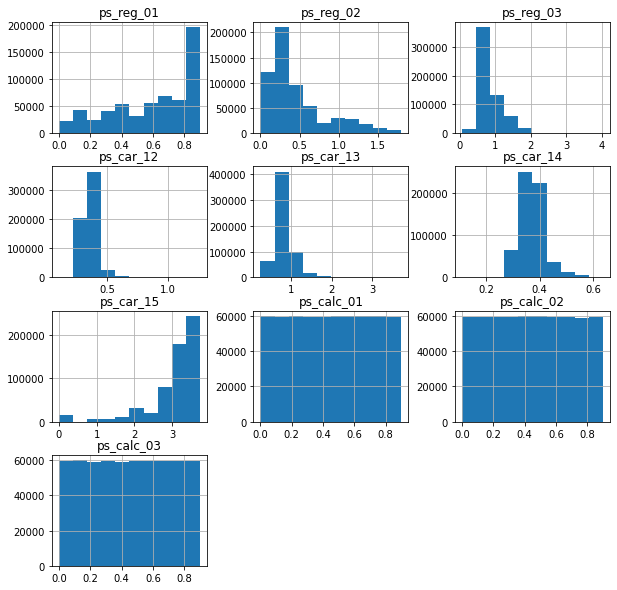

In [15]:
df[interval_cols].hist(figsize=(10,10))

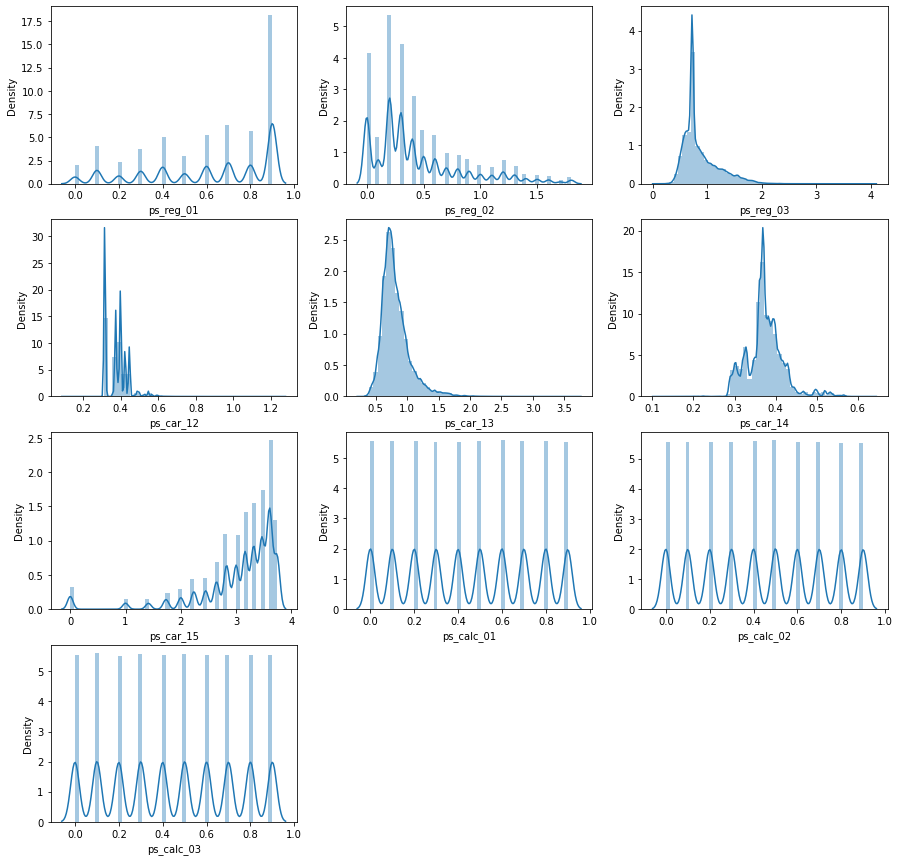

In [16]:
plt.figure(figsize=[15,15])
for i,col in enumerate(interval_cols):
  plt.subplot(4,3,i+1) 
  sns.distplot(df[col])
plt.show()

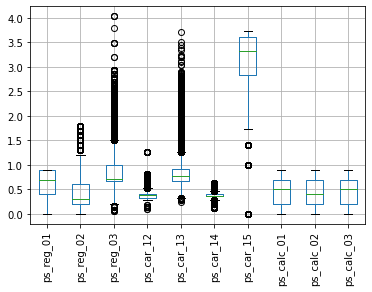

In [17]:
df[interval_cols].boxplot(rot=90)

In [18]:
outliers_indices=[]    
for column in interval_cols:
    Q1=df[column].quantile(0.25)
    Q3=df[column].quantile(0.75)
    IQR=Q3-Q1
    outliers=df[column][(df[column] < (Q1-1.5*IQR))| (df[column] > (Q3 + 1.5 * IQR))]
    if outliers.shape[0]>0:
        outliers_indices.extend(outliers.index)
        print(f"No of Outliers for column {column} is {outliers.shape[0]} and Percentage is {(outliers.shape[0]*100)/df.shape[0]}")#\nOutliers Index: {outliers.index}")

No of Outliers for column ps_reg_02 is 36793 and Percentage is 6.181494996740657
No of Outliers for column ps_reg_03 is 35514 and Percentage is 5.966613576339187
No of Outliers for column ps_car_12 is 15355 and Percentage is 2.579753096375745
No of Outliers for column ps_car_13 is 26913 and Percentage is 4.521582226164795
No of Outliers for column ps_car_14 is 30420 and Percentage is 5.110784056773049
No of Outliers for column ps_car_15 is 27409 and Percentage is 4.604913879424474


In [19]:
outliers_count=0
for i in list(set(outliers_indices)):
  outliers_count+=1
print(outliers_count)

117563


*   All interval features values are in between 0 to 4
*   All features having mean between 0 to 1 except for ps_car_15
*   Standard Deviation lies between 0 to 0.7
*   The data has outliers for 6 columns ps_reg_02 ,ps_reg_03,ps_car_12,
pas_car_13,ps_car_14,ps_car_15
*   117563 rows are outliers
*   The columns not having outliers are in range of 0 to 1



### Inference about Ordinal Variables 


In [20]:
# Dropping id column as too many ordinals to be handled and it assign higher rank for higher id.
df.drop('id',axis=1,inplace=True)
if 'id' in ordinal_cols:
  ordinal_cols.remove('id')

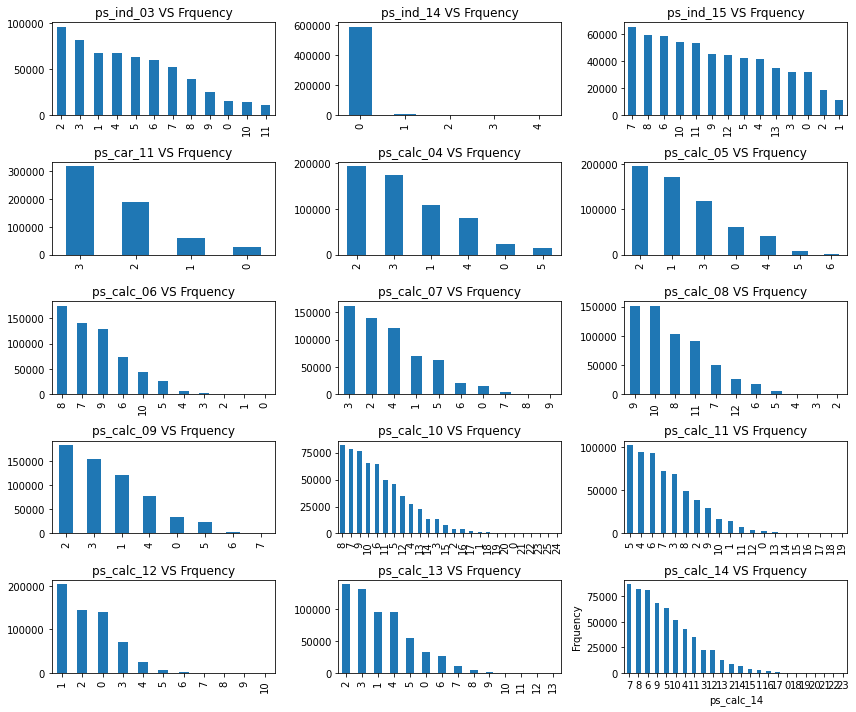

In [21]:
'''for column in ordinal_cols[1:]:
    fig, ax = plt.subplots()
    df[column].value_counts().plot(ax=ax, kind='bar',figsize=(3,3),title=  column+' VS Frquency')
    plt.xticks(rotation='horizontal')
    plt.xlabel(column)
    plt.ylabel('Frquency')'''

#https://stackoverflow.com/questions/64229894/how-to-fix-numpy-ndarray-object-has-no-attribute-get-figure-when-plotting-su
fig,ax=plt.subplots(5,3)
ax = ax.ravel()
for i,column in enumerate(ordinal_cols[1:]):
    df[column].value_counts().plot(ax=ax[i],kind='bar',figsize=(12,10),title=  column+' VS Frquency')
    plt.xticks(rotation='horizontal')
    plt.xlabel(column)
    plt.ylabel('Frquency')
plt.tight_layout()
#As you can see, the axis labels in these subplots overlap one another. This is visually unappealing.
#If you add the plt.tight_layout() statement to the end of this code block, this problem resolves itself.



* We can observe in all columns there is high to low range (rank wise) which indicates they are ordinal variables and in each column they are ranked 
* Since the values range between 0 to 24 we need to do scaling
 



### Inference about Binary Variables

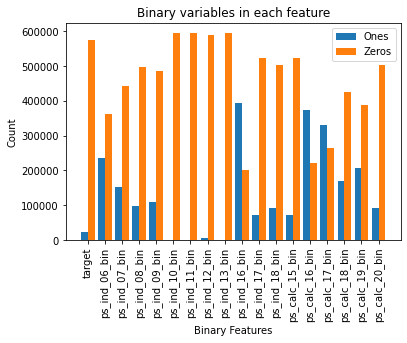

In [22]:

no_of_ones=[]
no_of_zeros=[]
count=0
for _ in binary_cols:
  count+=1
for column in binary_cols:
  no_of_ones.append(df[df[column]==1].shape[0])
  no_of_zeros.append(df[df[column]==0].shape[0])
  
X_axis = np.arange(count)
  
plt.bar(X_axis - 0.2, no_of_ones, 0.4, label = 'Ones')
plt.bar(X_axis + 0.2, no_of_zeros, 0.4, label = 'Zeros')
  
plt.xticks(X_axis, binary_cols,rotation='vertical')
plt.xlabel("Binary Features")
plt.ylabel("Count")
plt.title("Binary variables in each feature")
plt.legend()
plt.show()


*   In ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin ones ratio is very less
*   In most of Binary columns Zeros count is more
*   Only in ps_ind_16_bin and ps_calc_16_bin,ps_calc_17_bin ones are more
*   Mean is close to 0 and 75% is also 0 for most of columns.So we can conclude there are more zeros in majority of columns



### Which Interval Variables having strong correlation

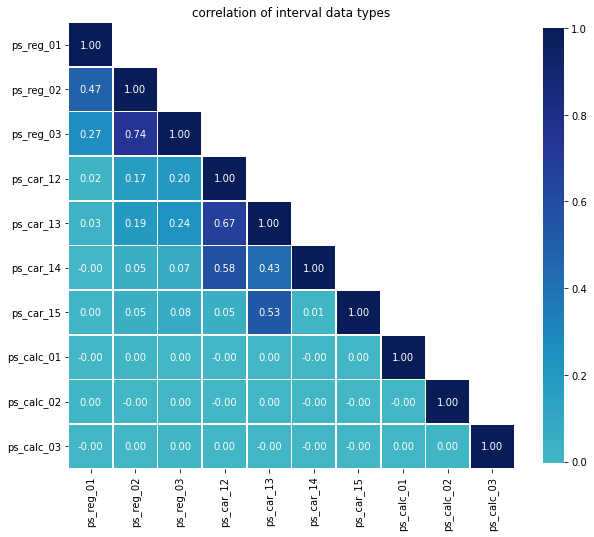

In [23]:
#cmap = sns.diverging_palette(220, 10, as_cmap=True)
'''fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(df[interval_cols].corr(), cmap='YlGnBu', vmax=1.0, center=0, fmt='.2f',
            square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .80})
plt.title("correlation of interval data types")
plt.show();'''
corr_mat = df[interval_cols].corr() 
corr_mat_mask = np.array(corr_mat)
corr_mat_mask[np.tril_indices_from(corr_mat)] = False 
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(corr_mat,mask=corr_mat_mask, cmap='YlGnBu', vmax=1.0, center=0, fmt='.2f',
            square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .80})
plt.title("correlation of interval data types")
plt.show()


In [24]:
df.drop(['ps_reg_03','ps_car_12'],axis=1,inplace=True)
if 'ps_reg_03' in interval_cols:
  interval_cols.remove('ps_reg_03')
if 'ps_car_12' in interval_cols:
  interval_cols.remove('ps_car_12')



*   ps_reg_02 and ps_reg_03 are more correlated and slightly with ps_reg_01.Hence dropped ps_reg_03
*   ps_car_12 ,pas_car_13 are highly correlated to each other and slightly with ps_car_15, ps_car_14.Hence dropped ps_car_12
*   Rest has no good correlation
*   Since ps_reg_02 and ps_reg_03 are highly correlated and both are having outliers and ps_reg_03 has 1lakh missing values.
let's drop ps_reg_03 column
*   Since ps_car_12,ps_car_13,ps_car_14,ps_car_15 are not highly correlated and though they are having outliers the outliers percentage is very less(2 to 4.5).So we are not dropping any column


###  Level Of Correlation among ordinal features


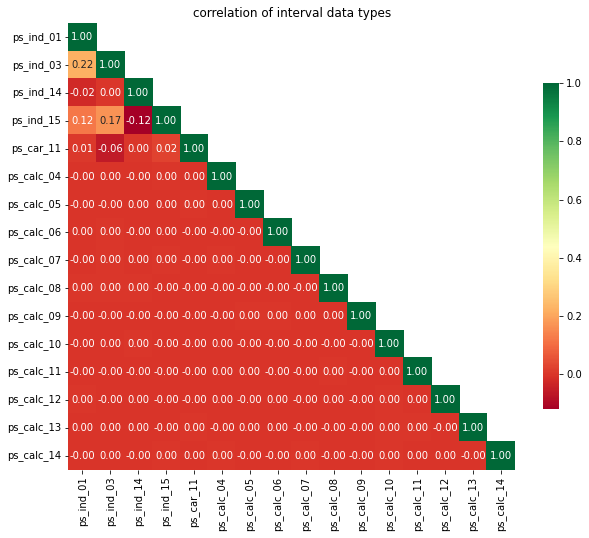

In [25]:
'''fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(df[ordinal_cols].corr(),cmap='RdYlGn',square=True,annot=True,fmt='.2f',cbar_kws={"shrink": .60})
plt.title("correlation of interval data types")
plt.show();'''
corr_mat = df[ordinal_cols].corr() 
corr_mat_mask = np.array(corr_mat)
corr_mat_mask[np.tril_indices_from(corr_mat)] = False 
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(corr_mat,mask=corr_mat_mask, cmap='RdYlGn', square=True,annot=True,fmt='.2f',cbar_kws={"shrink": .60})
plt.title("correlation of interval data types")
plt.show()

*   ps_ind_01 and ps_ind_03 has small correlation
*   Rest has no good correlation

### Checking target data is proportionate or not?

In [26]:
df['target'].value_counts()[0]/(df['target'].value_counts()[0]+df['target'].value_counts()[1]) *100

96.3552482140817


*   96% of target data is of one class and only 4% data is of another class
*   In binary data One class is below than 30%
*   So the target data is not proportionate 


###  Prefered way to balance the data is achieve balance of 12% using Undersampling or OverSampling.

#### As there are less than millions of records in our data let's go with oversampling and also check undersampling


In [27]:
#!pip install imblearn
from imblearn.over_sampling import SMOTE
smote_obj=SMOTE(random_state=23)
x_b=df.drop(['target'],axis=1)
y_b=df['target']
x_resampled,y_resampled = smote_obj.fit_resample(x_b,y_b)

In [28]:
y_resampled.value_counts()

0    573518
1    573518
Name: target, dtype: int64

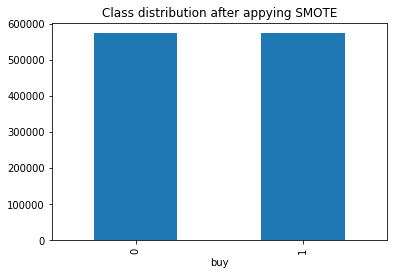

In [29]:
pd.Series(y_resampled).value_counts().plot(kind='bar', title='Class distribution after appying SMOTE', xlabel='buy')

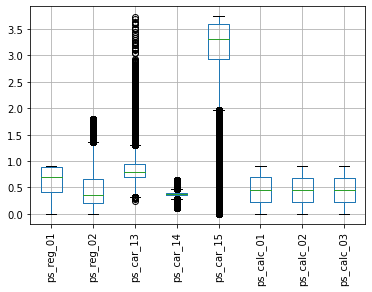

In [30]:
x_resampled[interval_cols].boxplot(rot=90)

### Undersampling achieving balance of 12%

In [31]:
def UnderSamplingRate(desired_balance,no_of_ones,no_of_zeros):
  return (1-desired_balance)*no_of_ones/(no_of_zeros*desired_balance)
desired_balance=0.12
no_of_ones=df[df['target']==1].shape[0]
no_of_zeros=df[df['target']==0].shape[0]
under_sampling_rate=UnderSamplingRate(desired_balance,no_of_ones,no_of_zeros)
target_zero_records=round(under_sampling_rate*no_of_zeros)
print(round(under_sampling_rate,2),target_zero_records,no_of_ones,no_of_zeros)

zero_indexes = df[df.target == 0].index
one_indexes = df[df.target == 1].index
from sklearn.utils import shuffle
undersampled_indexes = shuffle(zero_indexes,random_state=42,n_samples=target_zero_records)
final_indexes=list(one_indexes)+list(undersampled_indexes)
df_train=df.loc[final_indexes].reset_index(drop=True)
df_train['target'].value_counts()

0.28 159089 21694 573518


0    159089
1     21694
Name: target, dtype: int64

* Dropped Id column
* After OverSampling there is balanced dataset 
* After undersampling Now we have 159089 zeros and 21694 ones and achieved a balance of 12%

### Training Records after Oversampling and Undersampling achieving balance of 12%

In [32]:
print(f"Records After OverSampling: {x_resampled.shape[0]}")
#UnderSampling
print(f"Records After UnderSampling: { target_zero_records + no_of_ones}") #159089+21694 

Records After OverSampling: 1147036
Records After UnderSampling: 180783


*  Records After OverSampling: 1147036
*  Records After UnderSampling: 180783

###  HotEncoding For Categorical Features

#### One Hot Vector representation for categorical data before Resampling 

In [33]:
x_resampled_encoding=pd.get_dummies(x_resampled,columns=cat_cols)
df=pd.get_dummies(df,columns=cat_cols)

### Final Data for modeling

#### Initial data without Resampling and with Encoding

In [34]:
df

,target,ps_ind_01,ps_ind_03,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,...,ps_car_11_cat_95,ps_car_11_cat_96,ps_car_11_cat_97,ps_car_11_cat_98,ps_car_11_cat_99,ps_car_11_cat_100,ps_car_11_cat_101,ps_car_11_cat_102,ps_car_11_cat_103,ps_car_11_cat_104
0,0,2,5,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,7,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,5,9,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,2,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595207,0,3,10,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
595208,0,5,3,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
595209,0,1,10,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
595210,0,5,3,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


#### Data with Resampling and without Encoding

In [35]:
x_resampled

,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,2,2,5,1,0,0,1,0,0,0,...,9,1,5,8,0,1,1,0,0,1
1,1,1,7,0,0,0,0,1,0,0,...,3,1,1,9,0,1,1,0,1,0
2,5,4,9,1,0,0,0,1,0,0,...,4,2,7,7,0,1,1,0,1,0
3,0,1,2,0,0,1,0,0,0,0,...,2,2,4,9,0,0,0,0,0,0
4,0,2,0,1,0,1,0,0,0,0,...,3,1,1,3,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1147031,0,1,3,0,0,0,0,0,1,0,...,4,0,1,11,0,0,0,0,0,0
1147032,2,1,2,0,0,0,0,1,0,0,...,7,0,3,7,0,1,0,0,0,0
1147033,1,2,2,0,0,0,0,0,0,0,...,2,1,4,10,0,1,0,0,0,0
1147034,1,1,2,1,0,1,0,0,0,0,...,3,2,2,6,0,1,0,0,0,0


#### Data with Resampling and with Encoding

In [36]:
x_resampled_encoding

,ps_ind_01,ps_ind_03,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,...,ps_car_11_cat_95,ps_car_11_cat_96,ps_car_11_cat_97,ps_car_11_cat_98,ps_car_11_cat_99,ps_car_11_cat_100,ps_car_11_cat_101,ps_car_11_cat_102,ps_car_11_cat_103,ps_car_11_cat_104
0,2,5,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,7,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,5,9,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,2,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1147031,0,3,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1147032,2,2,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1147033,1,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1147034,1,2,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [37]:
df.to_csv('original_data_with_encoding.csv',index=False)
x_resampled.to_csv('resampled_without_encoding.csv',index=False)
x_resampled_encoding.to_csv('resampled_with_encoding.csv',index=False)
y_resampled.to_csv('y_resampled.csv',index=False)

###  Summary

*   Load the Data into DataFrame
*   Inference about the data
*   Finding the distribution of target variables
*   Split features into Categorical,Binary,Ordinal,Interval
*   Handled Missing Values
*   Found Outliers in continuous variables
*   Dropped Id column
*   Inferences about continuous,ordinal,binary variables through Visualization
*   Level of Correlation for interval,ordinal 
*   Keep only 1 column for columns having high correlation
*   Balanced the data by OverSampling(Smote algorithm)
*   OneHotEncoding for categorical variables
*   Saved CSV Files for data with and without Encoding

